In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Preprocessing and Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Dimensionality Reduction
from sklearn.decomposition import PCA

# Anomaly Detection Algorithms
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

# Visualization
from sklearn.manifold import TSNE

In [6]:
# Load the synthetic dataset
df = pd.read_csv('accounts_payable_synthetic_dataset.csv')

# Select features for anomaly detection
features = ['Gross Amount', 'VAT Amount']

# Preprocessing
def preprocess_data(df, features):
    # Create a copy of the dataframe
    data = df[features].copy()
    
    # Handle missing values
    imputer = SimpleImputer(strategy='median')
    data_imputed = imputer.fit_transform(data)
    
    # Standardize features
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_imputed)
    
    return data_scaled, scaler

# Preprocess the data
X_scaled, scaler = preprocess_data(df, features)

print("Preprocessing Complete:")
print(f"Scaled Data Shape: {X_scaled.shape}")

Preprocessing Complete:
Scaled Data Shape: (1000, 2)


In [7]:
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Print explained variance
print("\nPCA Explained Variance:")
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")
print(f"Cumulative Explained Variance: {sum(pca.explained_variance_ratio_)}")


PCA Explained Variance:
Explained Variance Ratio: [0.91705589 0.08294411]
Cumulative Explained Variance: 0.9999999999999999


In [8]:
# Anomaly Detection Function
def detect_anomalies(X_scaled, method_name, **kwargs):
    if method_name == 'DBSCAN':
        # DBSCAN
        detector = DBSCAN(**kwargs)
    elif method_name == 'OneClassSVM':
        # One-Class SVM
        detector = OneClassSVM(**kwargs)
    elif method_name == 'IsolationForest':
        # Isolation Forest
        detector = IsolationForest(**kwargs)
    else:
        raise ValueError("Invalid method name")
    
    # Fit and predict
    y_pred = detector.fit_predict(X_scaled)
    
    # Convert predictions
    anomalies = y_pred == -1
    
    return anomalies

# Detect anomalies using different methods
anomaly_results = {
    'DBSCAN': detect_anomalies(X_scaled, 'DBSCAN', eps=0.5, min_samples=5),
    'OneClassSVM': detect_anomalies(X_scaled, 'OneClassSVM', kernel='rbf', nu=0.1),
    'IsolationForest': detect_anomalies(X_scaled, 'IsolationForest', contamination=0.2)
}

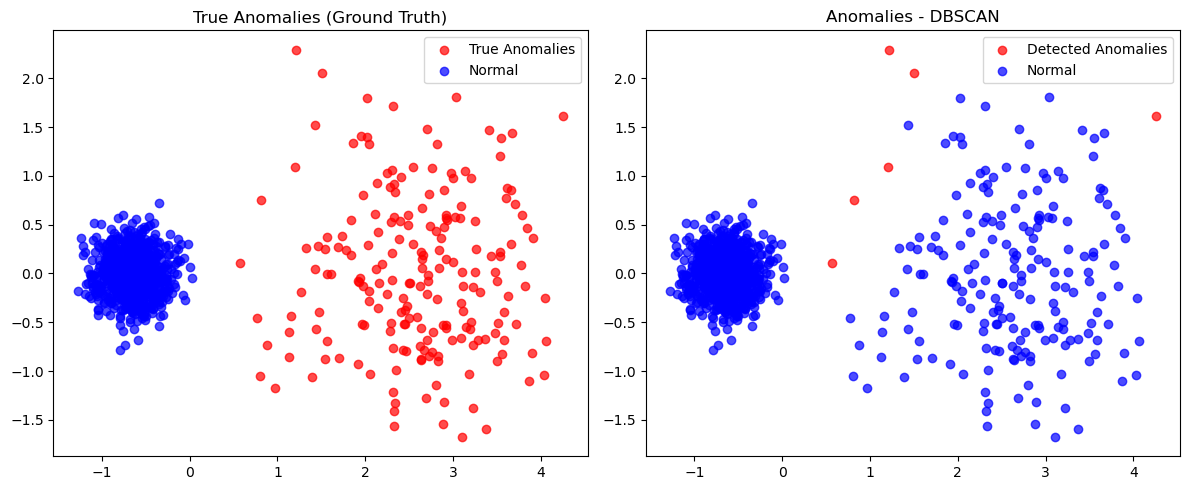


--- DBSCAN Anomaly Detection Report ---
Total Samples: 1000
True Anomalies: 200 (20.00%)
Detected Anomalies: 6 (0.60%)
True Positives: 6
False Positives: 0
False Negatives: 194
Precision: 1.00
Recall: 0.03
F1 Score: 0.06


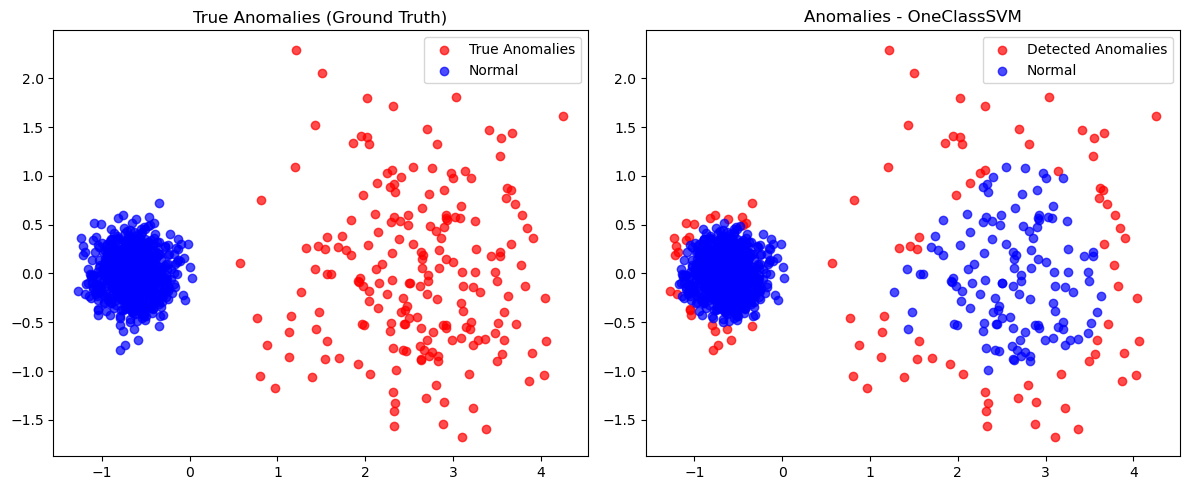


--- OneClassSVM Anomaly Detection Report ---
Total Samples: 1000
True Anomalies: 200 (20.00%)
Detected Anomalies: 100 (10.00%)
True Positives: 73
False Positives: 27
False Negatives: 127
Precision: 0.73
Recall: 0.36
F1 Score: 0.49


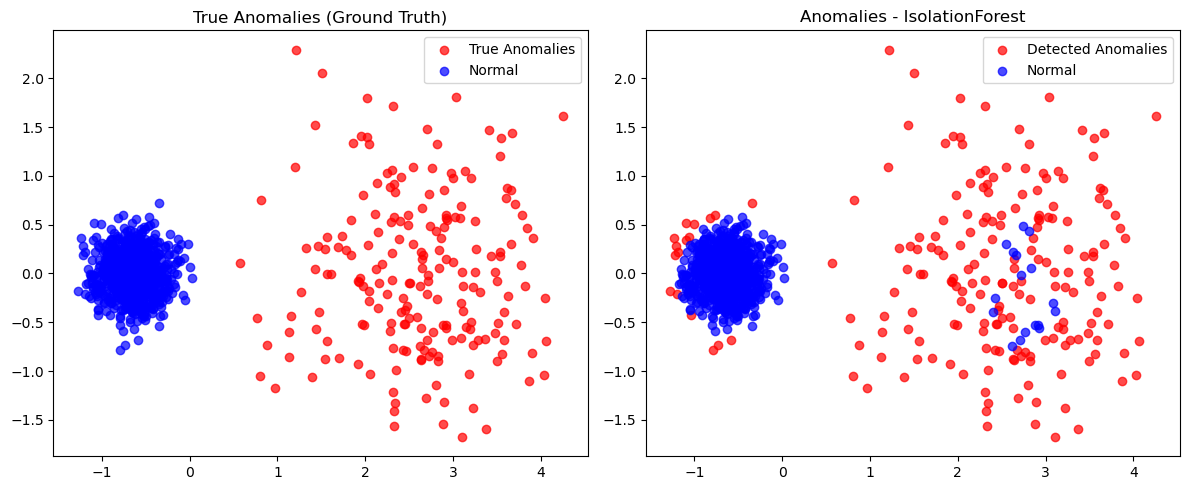


--- IsolationForest Anomaly Detection Report ---
Total Samples: 1000
True Anomalies: 200 (20.00%)
Detected Anomalies: 200 (20.00%)
True Positives: 183
False Positives: 17
False Negatives: 17
Precision: 0.92
Recall: 0.92
F1 Score: 0.92


In [10]:
# Visualization Function
def visualize_anomalies(X_pca, true_anomalies, predicted_anomalies, method_name):
    plt.figure(figsize=(12, 5))
    
    # True Anomalies
    plt.subplot(1, 2, 1)
    plt.scatter(X_pca[true_anomalies, 0], X_pca[true_anomalies, 1], 
                c='red', label='True Anomalies', alpha=0.7)
    plt.scatter(X_pca[~true_anomalies, 0], X_pca[~true_anomalies, 1], 
                c='blue', label='Normal', alpha=0.7)
    plt.title(f'True Anomalies (Ground Truth)')
    plt.legend()
    
    # Predicted Anomalies
    plt.subplot(1, 2, 2)
    plt.scatter(X_pca[predicted_anomalies, 0], X_pca[predicted_anomalies, 1], 
                c='red', label='Detected Anomalies', alpha=0.7)
    plt.scatter(X_pca[~predicted_anomalies, 0], X_pca[~predicted_anomalies, 1], 
                c='blue', label='Normal', alpha=0.7)
    plt.title(f'Anomalies - {method_name}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    # Reporting Function
def generate_anomaly_report(true_anomalies, predicted_anomalies, method_name):
    total_samples = len(true_anomalies)
    true_anomaly_count = sum(true_anomalies)
    predicted_anomaly_count = sum(predicted_anomalies)
    
    # Metrics
    true_positive = sum(true_anomalies & predicted_anomalies)
    false_positive = sum(~true_anomalies & predicted_anomalies)
    false_negative = sum(true_anomalies & ~predicted_anomalies)
    
    # Precision, Recall, F1 Score
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\n--- {method_name} Anomaly Detection Report ---")
    print(f"Total Samples: {total_samples}")
    print(f"True Anomalies: {true_anomaly_count} ({true_anomaly_count/total_samples*100:.2f}%)")
    print(f"Detected Anomalies: {predicted_anomaly_count} ({predicted_anomaly_count/total_samples*100:.2f}%)")
    print(f"True Positives: {true_positive}")
    print(f"False Positives: {false_positive}")
    print(f"False Negatives: {false_negative}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1_score:.2f}")

# Visualize and Report for each method
true_anomalies = df['Is Anomaly'].values

for method, predicted_anomalies in anomaly_results.items():
    visualize_anomalies(X_pca, true_anomalies, predicted_anomalies, method)
    generate_anomaly_report(true_anomalies, predicted_anomalies, method)

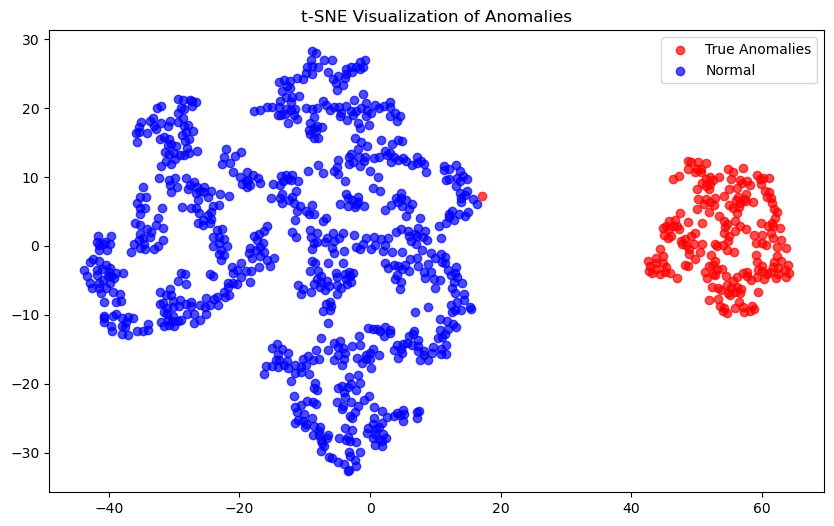

In [11]:
# t-SNE for non-linear dimensionality reduction
def tsne_visualization(X_scaled, true_anomalies):
    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)
    
    # Visualize
    plt.figure(figsize=(10, 6))
    plt.scatter(X_tsne[true_anomalies, 0], X_tsne[true_anomalies, 1], 
                c='red', label='True Anomalies', alpha=0.7)
    plt.scatter(X_tsne[~true_anomalies, 0], X_tsne[~true_anomalies, 1], 
                c='blue', label='Normal', alpha=0.7)
    plt.title('t-SNE Visualization of Anomalies')
    plt.legend()
    plt.show()

# Visualize using t-SNE
tsne_visualization(X_scaled, true_anomalies)

In [12]:
# Function for hyperparameter grid search
def hyperparameter_tuning(X_scaled, true_anomalies):
    # Define hyperparameter ranges
    dbscan_params = {
        'eps': [0.3, 0.5, 0.7],
        'min_samples': [3, 5, 7]
    }
    
    ocsvm_params = {
        'nu': [0.05, 0.1, 0.2],
        'kernel': ['rbf', 'sigmoid']
    }
    
    iforest_params = {
        'contamination': [0.1, 0.2, 0.3],
        'max_samples': [100, 'auto']
    }
    
    # Grid search and reporting function
    def grid_search(method, params, X_scaled, true_anomalies):
        best_f1 = 0
        best_params = None
        
        # Iterate through parameter combinations
        for param_combination in [dict(zip(params, v)) for v in zip(*params.values())]:
            pred_anomalies = detect_anomalies(X_scaled, method, **param_combination)
            
            # Calculate F1 score
            true_positive = sum(true_anomalies & pred_anomalies)
            false_positive = sum(~true_anomalies & pred_anomalies)
            false_negative = sum(true_anomalies & ~pred_anomalies)
            
            precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
            recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            if f1_score > best_f1:
                best_f1 = f1_score
                best_params = param_combination
        
        print(f"\n{method} Best Parameters:")
        print(best_params)
        print(f"Best F1 Score: {best_f1}")
        
        return best_params

    # Perform grid search for each method
    best_dbscan = grid_search('DBSCAN', dbscan_params, X_scaled, true_anomalies)
    best_ocsvm = grid_search('OneClassSVM', ocsvm_params, X_scaled, true_anomalies)
    best_iforest = grid_search('IsolationForest', iforest_params, X_scaled, true_anomalies)

hyperparameter_tuning(X_scaled, true_anomalies)


DBSCAN Best Parameters:
{'eps': 0.3, 'min_samples': 3}
Best F1 Score: 0.13084112149532712

OneClassSVM Best Parameters:
{'nu': 0.05, 'kernel': 'rbf'}
Best F1 Score: 0.30158730158730157

IsolationForest Best Parameters:
{'contamination': 0.2, 'max_samples': 'auto'}
Best F1 Score: 0.88
